# Setting up the environment

First, we set up our environment. We will be using a pre-compiled and packaged installation of OpenMM and the openmm-dlext plugin.
It will be downloaded from Google Drive and made accessible to the Python process running in this Colab instance.

In [1]:
%%bash

BASE_URL="https://drive.usercontent.google.com/download?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7"
COOKIES="/tmp/cookies.txt"
CONFIRMATION="$(wget -q --save-cookies $COOKIES --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')"

wget -q --load-cookies $COOKIES "$BASE_URL&confirm=$CONFIRMATION" -O pysages-env.zip
rm -rf $COOKIES

In [2]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [3]:
%%bash

mkdir -p $PYSAGES_ENV .
unzip -qquo pysages-env.zip -d $PYSAGES_ENV

In [4]:
import os
import sys

ver = sys.version_info
sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu:" + os.environ["LD_LIBRARY_PATH"]

## PySAGES

Next, we install PySAGES. The latest version is retrieved from GitHub and installed (along with its dependencies) using `pip`.

In [ ]:
!pip install -qq git+https://github.com/SSAGESLabs/PySAGES.git > /dev/null

# Harmonic Bias simulations

In [8]:
%%bash

mkdir /content/harmonic-bias
cd /content/harmonic-bias

A harmonic bias simulation constraints a collective variable with a harmonic potential. This is useful for a variety of advanced sampling methods, in particular, umbrella sampling.

For this Colab, we are using alanine dipeptide as the example molecule, a system widely-used for benchmarking enhanced sampling methods. So first, we fetch the molecule from the examples of PySAGES.

In [9]:
%%bash

# Download pdb file with the initial configuration of our system
wget -q https://raw.githubusercontent.com/SSAGESLabs/PySAGES/main/examples/inputs/alanine-dipeptide/adp-explicit.pdb

Next, we write a function that can generate an execution context for OpenMM. This is everything you would normally write in an OpenMM script, just wrapped as a function that returns the context of the simulation.

In [11]:
import numpy as np
import openmm
import openmm.app as app
import openmm.unit as unit


T = 298.15 * unit.kelvin
dt = 2.0 * unit.femtoseconds
adp_pdb = "adp-explicit.pdb"


def generate_simulation(pdb_filename=adp_pdb, T=T, dt=dt, **kwargs):
    """
    Generates a simulation context to which will attach our sampling method.
    """
    pdb = app.PDBFile(pdb_filename)

    ff = app.ForceField("amber99sb.xml", "tip3p.xml")
    cutoff_distance = 1.0 * unit.nanometer
    topology = pdb.topology
    system = ff.createSystem(
        topology, constraints = app.HBonds, nonbondedMethod = app.NoCutoff,
        nonbondedCutoff = cutoff_distance
    )

    positions = pdb.getPositions(asNumpy = True)

    integrator = openmm.LangevinIntegrator(T, 1 / unit.picosecond, dt)

    simulation = app.Simulation(topology, system, integrator)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()

    return simulation

The next step is to define the collective variable (CV). In this case, we choose the two dihedral angles on the molecule as defined by the atom positions. We also choose an equilibrium value to constrain the dihedrals and the corresponding spring constant.
The `HarmonicBias` class is responsible for introducing the bias into the simulation run.

In [12]:
import pysages

from pysages.colvars import DihedralAngle
from pysages.methods import HarmonicBias, HistogramLogger

In [ ]:
cvs = [DihedralAngle([4, 6, 8, 14]), DihedralAngle([6, 8, 14, 16])]
center = [-0.33*np.pi, -0.4*np.pi]
k = 100
method = HarmonicBias(cvs, k, center)

We now define a Histogram callback to log the measured values of the CVs and run the simulation for $10^4$ time steps. The `HistogramLogger` collects the state of the collective variable during the run.
Make sure to run with GPU support. Using the CPU platform with OpenMM is possible and supported, but can take a very long time.

In [13]:
callback = HistogramLogger(50)
pysages.run(method, generate_simulation, int(1e4), callback)

Next, we want to plot the histogram as recorded from the simulations.

In [14]:
bins = 25
lim = (-np.pi/2, -np.pi/4)
lims = [lim for i in range(2)]
hist, edges = callback.get_histograms(bins=bins, range=lims)
hist_list = [np.sum(hist, axis=(0)), np.sum(hist, axis=(1))]

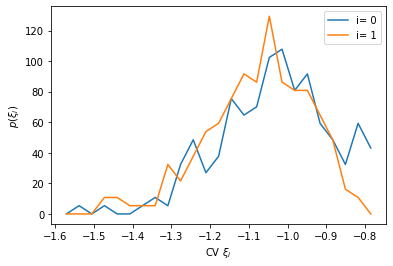

In [15]:
import matplotlib.pyplot as plt

x = np.linspace(lim[0], lim[1], hist_list[0].shape[0])

fig, ax = plt.subplots()

ax.legend(loc="best")
ax.set_xlabel(r"CV $\xi_i$")
ax.set_ylabel(r"$p(\xi_i)$")

for i in range(len(hist_list)):
    (line,) = ax.plot(x, hist_list[i], label="i= {0}".format(i))

fig.show()

We see how the dihedral angles are distributed. The histograms are not perfect in this example because we ran the simulation only for a few time steps and hence sampling is quite limited.